# Steps - 
1. Import libraries and modules
2. Load PMPM data into program
    1. Take Log Cost
3. Train Deep Learning Model for Feature Extraction / Projection in Latent Space
    1. Create Training Features: Data from 2017 aggregated. Features are - Age, Total Allow Amt, Gender, All the CC Codes.
    2. Create Training Labels: CC_Diabetes on January 2019 (at least 12 months apart).
    3. Create Test Features: Data from 2018 aggregated. Features are - Age, Total Allow Amt, Gender, All the CC Codes.
    4. Create Test Labels: CC_Diabetes on January 2020 (at least 12 months apart). 
    5. Define the Model architecture: (72->64->32->16->8->1). 5 Dense layers, with Batch Normalization, Dropout Regularization
    6. Model Fit: Train the model by fitting the training data with Callbacks, class-weights and other parameters
    7. Model Evaluation: Accuracy and Balanced Accuracy For Train, Validation, and Test Data, Plot Loss and Accuracy Curves. 
    8. Save Final Model: Save the final model in a particular format - pkl / h5. Two saved models, one without popping the final layer, and one with popped final layer.
4. Apply saved model
    1. Apply the unpopped model on the treated group in the original space and get the probability for a particular treated patient for getting CC_Diabetes.
    2. Classify this patient as healthy or sick based on a threshold on probabilty of getting CC_Diabetes (p=0.5)
    3. Divide treated population into two groups - healthy and sick based on probability of getting CC_Diabetes. p>=0.5 means sick in treated group, p<0.5 means healthy in treated group
    4. Merge each group with control population separately and then generate treatment effect for these two populations separately.
    5. Do the same for both the treated group with their features transformed and projected into latent space.

# 1. Import

In [1]:
%reload_ext autoreload
%autoreload 2

In [32]:
import data_process, data_functions, dowhy_methods
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from functools import reduce
from sklearn import preprocessing
from datetime import timedelta, datetime
import seaborn as sns
import warnings
from dowhy import CausalModel
import matplotlib.pyplot as plt

/home/nneehal/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
path_dict = {
    'data_path': '../../data',
    'temp_path': '../../temp',
    'aws_bucket':'cdphp-s3-us-e-p-pond',
    'canary_aws_path': 's3://cdphp-s3-us-e-p-pond/rpi/DataSources/PROGRAMS/',
    'canary_local_path': '../../data/CANARY',
    'canary_new_aws_path': 's3://cdphp-s3-us-e-p-pond/rpi/DataSources/FROM_POND/CA/Canary_detail_1220.parquet/',
    'canary_new_local_path': '../../data/CANARY_NEW',
    'canary_processed_local_path': '../../temp/CANARY.p',
    'biometrics_aws_path': 's3://cdphp-s3-us-e-p-pond/rpi/DataSources/BIOMETRICS202101/',
    'biometrics_local_path': '../../data/BIOMETRICS',
    'pmpm_aws_path': 's3://cdphp-s3-us-e-p-pond/rpi/DataSources/FROM_LAKE/PMPM/ANALYTIC_PMPM202101',
    'pmpm_local_path': '../../data/PMPM',
    'pmpm_processed_aws_path': 'rpi/DATA_GEORGE/PMPM_PICKLE/ELIGIBLE.p',
    'pmpm_processed_local_path': '../../temp/PMPM.p'
}

# 2. Load PMPM Data and Process


In [4]:
#load pmpm data only
#notebooks/causal_data_creation/biometric_matching_X
_, _, pmpm = data_process.load_data(path_dict)

### 2A. Take log of cost

In [7]:
def log_(x):
    return np.log(x) if x>0 else 0

In [5]:
pmpm.ALLOW_AMT = pmpm.ALLOW_AMT.apply(log_)

In [6]:
pmpm.head()

PERS_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT  CC_ADHD  \
0  2570122  202002        M               95  10.606387      0.0   
1  2570122  201810        M               94   9.895304      0.0   
2  2570268  201704        F               93   8.501470      0.0   
3  2570268  201807        F               94   5.446737      0.0   
4  2570268  201801        F               93   7.928766      0.0   

   CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  ...  \
0           0.0                1.0     0.0        1.0  ...   
1           0.0                0.0     0.0        1.0  ...   
2           1.0                1.0     0.0        1.0  ...   
3           1.0                1.0     0.0        1.0  ...   
4           1.0                1.0     0.0        1.0  ...   

   CC_PROSTATE_CANCER  CC_PTSD  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  \
0                 0.0      0.0               0.0                     1.0   
1                 0.0      0.0               0.0                     0.0   
2                 0.0      0.0               0.0                     0.0   
3                 0.0      0.0               0.0                     0.0   
4                 0.0      0.0               0.0                     0.0   

   CC_SPINAL_CORD  CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  \
0             0.0              0.0        0.0         0.0                 0.0   
1             0.0              0.0        0.0         0.0                 0.0   
2             0.0              0.0        0.0         0.0                 0.0   
3             0.0              0.0        0.0         0.0                 0.0   
4             0.0              0.0        0.0         0.0                 0.0   

   CC_VISUAL_IMPAIR  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  

[5 rows x 74 columns]

# 3. Training the Deep Neural Network

### 3A. Create Training Feature

In [7]:
train_X = (pmpm.query("MYR>=201701 & MYR<=201712 & PERS_ID>'0'")
    .sort_values(by=['PERS_ID','MYR'])
    .drop_duplicates(subset=['PERS_ID','MYR'])
    .replace({'MBR_GNDR': {'M':0, 'F':1}})
)
disease_cols = [col for col in train_X.columns.tolist() if ('CC' in col) or ('ALLOW' in col)]
A = pd.pivot_table(data=train_X,index="PERS_ID",values=disease_cols, aggfunc="sum")
A.ALLOW_AMT = pd.pivot_table(data=train_X,index="PERS_ID",values=['ALLOW_AMT'], aggfunc=np.median).ALLOW_AMT
B = pd.pivot_table(data=train_X, index="PERS_ID", values=['AGE_AT_MIDMONTH', 'MBR_GNDR'], aggfunc="max")
train_X = B.merge(A, how='left', on='PERS_ID').reset_index()

**Remove already diabetic people from training (NEW)**

In [8]:
train_X = train_X.query("CC_DIABETES==0")

### 3C. Create Training Labels

In [9]:
train_Y = (pmpm.query("MYR>=201901 & MYR<=201901 & PERS_ID>'0'")
    .sort_values(by=['PERS_ID','MYR'])
    .drop_duplicates(subset=['PERS_ID','MYR'])
    .replace({'MBR_GNDR': {'M':0, 'F':1}})
)
disease_cols = [col for col in train_Y.columns.tolist() if ('CC' in col) or ('ALLOW' in col)]
A = pd.pivot_table(data=train_Y,index="PERS_ID",values=disease_cols, aggfunc="sum")
B = pd.pivot_table(data=train_Y, index="PERS_ID", values=['AGE_AT_MIDMONTH', 'MBR_GNDR'], aggfunc="max")
train_Y = B.merge(A, how='left', on='PERS_ID').reset_index()

In [10]:
commonPMPM = np.intersect1d(train_X.PERS_ID, train_Y.PERS_ID)
train_X = train_X[train_X.PERS_ID.isin(commonPMPM)].set_index('PERS_ID')
train_Y = train_Y[train_Y.PERS_ID.isin(commonPMPM)].set_index('PERS_ID')

**Calculate Class Weights**

In [11]:
total = train_Y.CC_DIABETES.value_counts().sum()
neg = train_Y.CC_DIABETES.value_counts()[0]
pos = train_Y.CC_DIABETES.value_counts()[1]

weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Total:{total}, Pos:{pos}, Neg:{neg}")

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Total:103313, Pos:1941, Neg:101372
Weight for class 0: 0.51
Weight for class 1: 26.61


### 3C. Creating Test Feature

In [12]:
test_X = (pmpm.query("MYR>=201801 & MYR<=201812 & PERS_ID>'0'")
    .sort_values(by=['PERS_ID','MYR'])
    .drop_duplicates(subset=['PERS_ID','MYR'])
    .replace({'MBR_GNDR': {'M':0, 'F':1}})
)
disease_cols = [col for col in test_X.columns.tolist() if ('CC' in col) or ('ALLOW' in col)]
A = pd.pivot_table(data=test_X,index="PERS_ID",values=disease_cols, aggfunc="sum")
A.ALLOW_AMT = pd.pivot_table(data=test_X,index="PERS_ID",values=['ALLOW_AMT'], aggfunc=np.median).ALLOW_AMT
B = pd.pivot_table(data=test_X, index="PERS_ID", values=['AGE_AT_MIDMONTH', 'MBR_GNDR'], aggfunc="max")
test_X = B.merge(A, how='left', on='PERS_ID').reset_index()

**Remove already diabetic people from test (NEW)**

In [13]:
test_X = test_X.query("CC_DIABETES==0")

### 3D. Creating Test Labels

In [14]:
test_Y = (pmpm.query("MYR>=202001 & MYR<=202001 & PERS_ID>'0'")
    .sort_values(by=['PERS_ID','MYR'])
    .drop_duplicates(subset=['PERS_ID','MYR'])
    .replace({'MBR_GNDR': {'M':0, 'F':1}})
)
disease_cols = [col for col in test_Y.columns.tolist() if ('CC' in col) or ('ALLOW' in col)]
A = pd.pivot_table(data=test_Y,index="PERS_ID",values=disease_cols, aggfunc="sum")
B = pd.pivot_table(data=test_Y, index="PERS_ID", values=['AGE_AT_MIDMONTH', 'MBR_GNDR'], aggfunc="max")
test_Y = B.merge(A, how='left', on='PERS_ID').reset_index()

In [15]:
commonPMPMtest = np.intersect1d(test_X.PERS_ID, test_Y.PERS_ID)
test_X = test_X[test_X.PERS_ID.isin(commonPMPMtest)].set_index('PERS_ID')
test_Y = test_Y[test_Y.PERS_ID.isin(commonPMPMtest)].set_index('PERS_ID')

**Final Train Labels**

In [16]:
train_labels = train_Y.CC_DIABETES.values
test_labels = test_Y.CC_DIABETES.values

### 3E. Define Model Architecture

In [17]:
import tensorflow as tf
from tensorflow import keras
from numpy import loadtxt
import tensorflow.keras.backend as K

**Callback for Early Stopping**

In [18]:
#define callbacks
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=10, mode='max', baseline=0.95)
]

**Model Define**

In [19]:
def make_model(output_bias=None):
    
    #output bias initializer
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    #sequential model
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(64, input_dim=72, activation='relu'))
    model.add(keras.layers.BatchNormalization(scale=False))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.BatchNormalization(scale=False))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(16, activation='relu'))
    model.add(keras.layers.BatchNormalization(scale=False))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(8, activation='relu', name='latent'))
    model.add(keras.layers.BatchNormalization(scale=False))
    model.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))
    
    #compile
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=1e-3),
        loss=tf.keras.losses.binary_crossentropy,
        metrics=['accuracy']
    )
    
    return model
    

**Model Summary**

In [20]:
baseline_model = make_model()
baseline_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                4672      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                192       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                96        
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
__________

### 3F. Model Fit

In [21]:
baseline_history = baseline_model.fit(train_X.values, train_labels, epochs=100, validation_split=0.2, batch_size=128, callbacks=my_callbacks, class_weight=class_weight)

Train on 82650 samples, validate on 20663 samples
Epoch 1/100
82650/82650 [==============================] - 3s 34us/step - loss: 0.7112 - acc: 0.6608 - val_loss: 0.6532 - val_acc: 0.7541
Epoch 2/100
82650/82650 [==============================] - 2s 25us/step - loss: 0.6529 - acc: 0.7345 - val_loss: 0.6558 - val_acc: 0.7598
Epoch 3/100
82650/82650 [==============================] - 2s 24us/step - loss: 0.6394 - acc: 0.7174 - val_loss: 0.6481 - val_acc: 0.8027
Epoch 4/100
82650/82650 [==============================] - 2s 24us/step - loss: 0.6359 - acc: 0.7363 - val_loss: 0.6392 - val_acc: 0.7404
Epoch 5/100
82650/82650 [==============================] - 2s 24us/step - loss: 0.6339 - acc: 0.7067 - val_loss: 0.6395 - val_acc: 0.7692
Epoch 6/100
82650/82650 [==============================] - 2s 24us/step - loss: 0.6279 - acc: 0.7252 - val_loss: 0.6390 - val_acc: 0.7336
Epoch 7/100
82650/82650 [==============================] - 2s 24us/step - loss: 0.6254 - acc: 0.7347 - val_loss: 0.6411 - 

In [22]:
#freeze all the layers
for layer in baseline_model.layers:
    layer.trainable=False

### 3G. Model Evaluation

In [23]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
    metrics= ['loss', 'acc']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0,1])
        plt.legend()

**Accuracy**

In [24]:
_, train_accuracy = baseline_model.evaluate(train_X.values, train_labels)
print('Train Accuracy: %.2f' % (train_accuracy*100))
_, test_accuracy = baseline_model.evaluate(test_X.values, test_labels)
print('Test Accuracy: %.2f' % (test_accuracy*100))

103313/103313 [==============================] - 2s 18us/step
Train Accuracy: 67.53
115228/115228 [==============================] - 2s 17us/step
Test Accuracy: 67.55


**Plot**

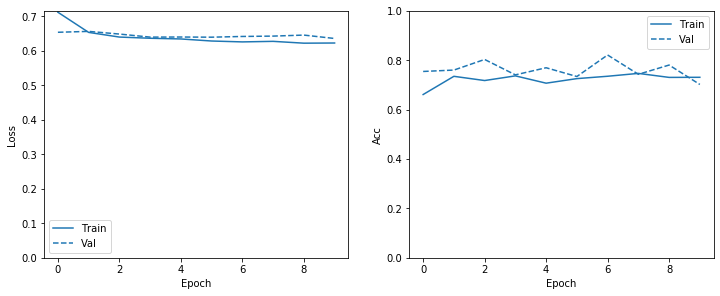

In [25]:
plot_metrics(baseline_history)

**Balanced Accuracy: average of recall obtained on each class**

In [26]:
train_predictions_baseline = baseline_model.predict(train_X.values)
test_predictions_baseline = baseline_model.predict(test_X.values)

In [27]:
from sklearn.metrics import balanced_accuracy_score
print(f"Train Balanced Accuracy: {balanced_accuracy_score(train_labels, np.round_(train_predictions_baseline)):0.2f}")
print(f"Test Balanced Accuracy: {balanced_accuracy_score(test_labels, np.round_(test_predictions_baseline)):0.2f}")

Train Balanced Accuracy: 0.65
Test Balanced Accuracy: 0.63


In [30]:
## save the model
baseline_model.save('./TF_Model_unpopped')

**Pop the last layer**

In [31]:
baseline_model._layers.pop()
model = tf.keras.Model(baseline_model.input, baseline_model.layers[-1].output)

**Check the latent projection of test data for Sanity Check**

In [32]:
#sanity check
model.predict(test_X).shape

### 3H. Save the Model

In [33]:
## save the model
model.save('./TF_Model_popped')

# 4. Project the Processed Data onto the Latent Space

### 4A. Load Saved Model

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np, pandas as pd

In [3]:
model_unpopped = models.load_model("./TF_Model_unpopped", compile=False)
model_popped = models.load_model("./TF_Model_popped", compile=False)

### 4B. Load Processed Data for DoWhy

In [4]:
matching_data = "../../matching_data/data_DIAB_ONSET.p"
data = pd.read_pickle(matching_data)

**Format Data for Deep Neural Net**

In [5]:
A = data.loc[:,["AGE_AT_MIDMONTH", "MBR_GNDR", "ALLOW_AMT"]]
B = data.loc[:,"CC_ADHD":"CC_VISUAL_IMPAIR"]
X = A.merge(B, how='left', left_index=True, right_index=True)
T = data.TREATED
Y = data.OUTCOME

**Log the Cost**

In [8]:
X.ALLOW_AMT = X.ALLOW_AMT.apply(log_)

### 4C. Experiment on treated subgroup based on probability
Note: <br/>
Sick_treated, PSS effect: -3.666e-05, Refutes: (-3.590e-05, 0.006, -5.149e-05) <br/>
Healthy_treated, PSS effect: -0.000, Refutes: (-8.777e-05, -0.002, -6.026e-05) <br/>
Transformed_sick_treated, PSS effect: -0.003, Refutes (...) <br/>
Transformed_healthy_treated, PSS effect: 0.001, Refutes (...) <br/>

In [9]:
treated_ = pd.concat([X,Y,T], axis=1).query("TREATED==1")
treated_['PROBA'] = np.squeeze(model_unpopped.predict_proba(treated_.iloc[:,:-2]))

In [10]:
controls_ = pd.concat([X,Y,T], axis=1).query("TREATED==0")

In [11]:
treated_sick_ = treated_.query("PROBA>=0.5").drop(["PROBA"], axis=1)
treated_healthy_ = treated_.query("PROBA<0.5").drop(["PROBA"], axis=1)

In [12]:
pop_sick_ = pd.concat([controls_, treated_sick_], axis=0).reset_index(drop=True).astype({"TREATED":'bool'}, copy=False)
pop_healthy_ = pd.concat([controls_, treated_healthy_], axis=0).reset_index(drop=True).astype({"TREATED":'bool'}, copy=False)

In [112]:
methods = {'LR':  'backdoor.linear_regression', 
           'PSM': 'backdoor.propensity_score_matching',
           'PSS': 'backdoor.propensity_score_stratification', 
           'PSW': 'backdoor.propensity_score_weighting'}
treatment_label='TREATED'
outcome_label = 'OUTCOME'
common_causes_list = X.columns.tolist()
target_units = 'att'
warnings.filterwarnings("ignore", category=FutureWarning)
causal_model, identified_estimand, estimate = dowhy_methods.run_do_why(pop_sick_, treatment_label, outcome_label, common_causes_list, methods['PSM'], target_units)

### Project X into latent space

In [107]:
# pop_sick_ = pop_sick_.drop(["propensity_score", "strata", "dbar", "d_y", "dbar_y"], axis=1)
# pop_healthy_ = pop_healthy_.drop(["propensity_score", "strata", "dbar", "d_y", "dbar_y"], axis=1)

In [13]:
pop_sick_.head()

AGE_AT_MIDMONTH  MBR_GNDR  ALLOW_AMT  CC_ADHD  CC_ALZHEIMER  \
0               38         1   5.062595      0.0           0.0   
1               39         1   0.000000      0.0           0.0   
2               39         1   0.000000      0.0           0.0   
3               39         1   0.000000      0.0           0.0   
4               39         1   0.000000      0.0           0.0   

   CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  \
0                0.0     0.0        0.0                  0.0           0.0   
1                0.0     0.0        0.0                  0.0           0.0   
2                0.0     0.0        0.0                  0.0           0.0   
3                0.0     0.0        0.0                  0.0           0.0   
4                0.0     0.0        0.0                  0.0           0.0   

   ...  CC_SCHIZOPHRENIA  CC_SCHIZOPHRENIA_OTHER  CC_SPINAL_CORD  \
0  ...               0.0                     0.0             0.0   
1  ...               0.0                     0.0             0.0   
2  ...               0.0                     0.0             0.0   
3  ...               0.0                     0.0             0.0   
4  ...               0.0                     0.0             0.0   

   CC_SPINA_BIFIDA  CC_STROKE  CC_TOBACCO  CC_TRAUMATIC_BRAIN  \
0              0.0        0.0         0.0                 0.0   
1              0.0        0.0         0.0                 0.0   
2              0.0        0.0         0.0                 0.0   
3              0.0        0.0         0.0                 0.0   
4              0.0        0.0         0.0                 0.0   

   CC_VISUAL_IMPAIR  OUTCOME  TREATED  
0               0.0      0.0    False  
1               0.0      0.0    False  
2               0.0      0.0    False  
3               0.0      0.0    False  
4               0.0      0.0    False  

[5 rows x 74 columns]

In [21]:
latent_sick_ = model_popped.predict(pop_sick_.loc[:,"AGE_AT_MIDMONTH":"CC_VISUAL_IMPAIR"])
latent_healthy_ = model_popped.predict(pop_healthy_.loc[:,"AGE_AT_MIDMONTH":"CC_VISUAL_IMPAIR"])

In [22]:
latent_dim = 8
latent_col_labels = []
for i in range(latent_dim):
    latent_col_labels.append("x"+str(i+1))
latent_sick_ = pd.DataFrame(latent_sick_, columns=latent_col_labels)
latent_healthy_ = pd.DataFrame(latent_healthy_, columns=latent_col_labels)

In [29]:
latent_sick_ = pd.concat([latent_sick_, pop_sick_.OUTCOME,pop_sick_.TREATED], axis=1)
latent_healthy_ = pd.concat([latent_healthy_, pop_healthy_.OUTCOME,pop_healthy_.TREATED], axis=1)

In [35]:
methods = {'LR':  'backdoor.linear_regression', 
           'PSM': 'backdoor.propensity_score_matching',
           'PSS': 'backdoor.propensity_score_stratification', 
           'PSW': 'backdoor.propensity_score_weighting'}
treatment_label='TREATED'
outcome_label = 'OUTCOME'
common_causes_list = latent_col_labels
target_units = 'att'
warnings.filterwarnings("ignore", category=FutureWarning)
causal_model, identified_estimand, estimate = dowhy_methods.run_do_why(latent_healthy_, treatment_label, outcome_label, common_causes_list, methods['PSS'], target_units)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['TREATED'] on outcome ['OUTCOME']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['x5', 'x8', 'U', 'x2', 'x3', 'x6', 'x4', 'x7', 'x1']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Step 1: Causal Model Created
Step 2: Estimand Identified


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: OUTCOME~TREATED+x5+x8+x2+x3+x6+x4+x7+x1
/usr/local/lib64/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Step 3: Estimated the treatment effect
Causal Estimate is -0.0017492084034583253
Step 4: Refutation


INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: OUTCOME~TREATED+x5+x8+x2+x3+x6+x4+x7+x1+w_random
/usr/local/lib64/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


a. After random common cause refutation --
Refute: Add a Random Common Cause
Estimated effect:(-0.0017492084034583253,)
New effect:(-0.0017496800493724905,)



INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: OUTCOME~placebo+x5+x8+x2+x3+x6+x4+x7+x1
/usr/local/lib64/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


b. After placebo treatment refutation --
Refute: Use a Placebo Treatment
Estimated effect:(-0.0017492084034583253,)
New effect:(-0.0021624323283213594,)



INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: OUTCOME~TREATED+x5+x8+x2+x3+x6+x4+x7+x1
/usr/local/lib64/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


c. After random subset refutation --
Refute: Use a subset of data
Estimated effect:(-0.0017492084034583253,)
New effect:(-0.0017662816436044978,)

